In [4]:
site = 'addis_ababa'



#scenario = "ssp245"
scenario = "ssp585"

In [5]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [6]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
!pip install cftime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.5 MB/s eta 0:00:00


In [8]:
import xarray as xr
import pandas as pd
import numpy as np
from prophet import Prophet
#from neuralprophet import NeuralProphet
#from fbprophet import Prophet
import matplotlib.pyplot as plt
import pickle
import cftime
import os
import sys

In [9]:
#path = '/content/drive/MyDrive/Precipitation_Projection_AIMS/'

calib_start = pd.to_datetime('1985-01-01')
valid_end = pd.to_datetime('2014-12-31')

n_days = (valid_end - calib_start).days
n_calib = int(n_days*0.8)

calib_end = calib_start + pd.Timedelta(days=n_calib)

valid_start = calib_end + pd.Timedelta(days=1)
valid_end = valid_start + pd.Timedelta(days=n_days-n_calib)

projection_start = pd.to_datetime('2015-01-01')
projection_end = pd.to_datetime('2100-12-31')


print(f"Calibration period: {calib_start} to {calib_end}")
print(f"Validation period: {valid_start} to {valid_end}")

Calibration period: 1985-01-01 00:00:00 to 2008-12-30 00:00:00
Validation period: 2008-12-31 00:00:00 to 2015-01-01 00:00:00


In [ ]:
path = '/content/drive/MyDrive/Precipitation_Projection_AIMS/'
if os.path.exists(path):
  sys.path.append(path)
else:
  path = os.getcwd()

print(f'path: {path}')
assert os.path.exists(path+ f'data/{site}')
directory_data = path + f'data/{site}/'

directory_training = directory_data + scenario + "/" + "training/"
directory_validation = directory_data + scenario + "/" + "validation/"
directory_projection = directory_data + scenario + "/" + "projection/"

if not os.path.exists(directory_training):
  os.makedirs(directory_training)
if not os.path.exists(directory_validation):
  os.makedirs(directory_validation)
if not os.path.exists(directory_projection):
  os.makedirs(directory_projection)

path: /content/drive/MyDrive/Precipitation_Projection_AIMS/


In [ ]:
import dqm
import manage_files

In [ ]:
data_obs = xr.open_dataset(directory_data + f'precip_cpc_{site}.nc')
data_hist = xr.open_dataset(directory_data + f'pr_historical_{site}_ensmean.nc')
data_model = xr.open_dataset(directory_data + f'pr_{scenario}_{site}_ensmean.nc')

In [ ]:
# Convert to DataFrame and reset index to have 'time' as a column
df_hist = data_hist.to_dataframe()
df_hist = df_hist.reset_index()

#==============================================================
df_obs = data_obs.to_dataframe()
df_obs = df_obs.reset_index() # Reset the index to default integer index

#===========================================================
df_model = data_model.to_dataframe()
df_model = df_model.reset_index()

#===========================================================


print(f"{'df_hist':<7},  {str(df_hist.shape)},  {list(df_hist.columns)}")
print(f"{'df_obs':<7},  {str(df_obs.shape)},  {list(df_obs.columns)}")
print(f"df_{scenario},  {str(df_model.shape)},  {list(df_model.columns)}")

df_hist,  (10800, 4),  ['time', 'lon', 'lat', 'pr']
df_obs ,  (10592, 4),  ['time', 'lon', 'lat', 'precip']
df_ssp245,  (30960, 4),  ['time', 'lon', 'lat', 'pr']


In [ ]:
# prompt: écrire une fonction pour afficher le nombre de points de collecte presen dans chaque dataframe (cela en comptant le nombre de pairs longitude-latitude différente), afficher le pas de temps dans chaque df, ainisi que les dates de debut de collecte et de fin

def analyze_dataframes(dfs):
  """
  Analyze a list of dataframes to display information about collection points,
  time step, and start/end dates.

  Args:
    dfs: A dictionary where keys are dataframe names and values are the dataframes.
  """
  for name, df in dfs.items():
    print(f"--- Analysis for {name} ---")

    # Count unique latitude-longitude pairs (collection points)
    if 'lat' in df.columns and 'lon' in df.columns:
      unique_points = df[['lat', 'lon']].drop_duplicates().shape[0]
      print(f"Number of collection points: {unique_points}")
      print(df[['lat', 'lon']].drop_duplicates())

    else:
      print("Latitude and longitude columns not found.")

    # Determine time step
    if 'time' in df.columns and len(df['time']) > 1:
        # Ensure time column is datetime type
        if not pd.api.types.is_datetime64_any_dtype(df['time']):
            try:
                df['time'] = pd.to_datetime(df['time'])
            except Exception as e:
                print(f"Could not convert 'time' column to datetime: {e}")
                time_step = "Unknown (time conversion failed)"
                start_date = "Unknown (time conversion failed)"
                end_date = "Unknown (time conversion failed)"
                continue # Skip to the next dataframe
        else:
            time_diffs = df['time'].diff().dropna()
            if len(time_diffs) > 0:
                time_step = time_diffs.mode()[0]
                print(f"Estimated time step: {time_step}")
            else:
                time_step = "Cannot determine time step (less than 2 time entries)"
                print(time_step)

        # Display start and end dates
        start_date = df['time'].min()
        end_date = df['time'].max()
        print(f"Start date: {start_date}")
        print(f"End date: {end_date}")

    else:
      print("Time column not found or insufficient data.")

    print("-" * (len(f"--- Analysis for {name} --- \n")))


# Create a dictionary of your dataframes
dataframes = {
    'df_hist': df_hist,
    'df_obs': df_obs,
    f'df_{scenario}': df_model
}

# Call the function with your dictionary of dataframes
analyze_dataframes(dataframes)


--- Analysis for df_hist ---
Number of collection points: 1
     lat      lon
0  9.005  38.7636
Estimated time step: 1 days 00:00:00
Start date: 1985-01-01 12:00:00
End date: 2014-07-27 12:00:00
------------------------------
--- Analysis for df_obs ---
Number of collection points: 1
     lat      lon
0  9.005  38.7636
Estimated time step: 1 days 00:00:00
Start date: 1985-01-01 00:00:00
End date: 2014-12-31 00:00:00
-----------------------------
--- Analysis for df_ssp245 ---
Number of collection points: 1
     lat      lon
0  9.005  38.7636
Estimated time step: 1 days 00:00:00
Start date: 2015-01-01 12:00:00
End date: 2099-10-06 12:00:00
--------------------------------


In [ ]:
# Create a dictionary and standardize the precipitation column name to 'precip' for easier processing
df_s = {'obs': df_obs, 'hist' : df_hist, scenario : df_model}

for key, val in df_s.items():
    df_s[key] = val.copy()
    # Find the column containing 'precip' (case-insensitive) and rename to 'precip'
    col_precip_list = [col for col in df_s[key].columns if 'precip' in col.lower()]
    if not col_precip_list:
        # This should not happen if the previous renames worked, but as a safety check
        print(f"Warning: No column containing 'precip' found in dataframe '{key}'. Columns are: {df_s[key].columns}")
        # Attempt to find a 'pr' column if 'precip' wasn't found after rename (fallback)
        col_precip_list = [col for col in df_s[key].columns if 'pr' in col.lower()]
        if not col_precip_list:
             raise ValueError(f"Could not find 'precip' or 'pr' column in dataframe '{key}'. Cannot proceed.")

    col_precip = col_precip_list[0] # Take the first match
    if col_precip != 'precip': # Only rename if the name isn't already 'precip'
         df_s[key].rename(columns={col_precip: 'precip'}, inplace=True)

    # Ensure 'time' is datetime and normalize to remove time component
    # Use errors='coerce' to turn invalid parsing into NaT (Not a Time)
    #df_s[key]['time'] = pd.to_datetime(df_s[key]['time'], errors='coerce').dt.normalize()

    df_s[key]['time'] = df_s[key]['time'].dt.strftime('%Y-%m-%d')
    df_s[key]['time'] = pd.to_datetime(df_s[key]['time'])
    df_s[key]['time'] = df_s[key]['time'].dt.normalize()

    # Drop rows where time conversion failed - crucial!
    df_s[key].dropna(subset=['time', 'precip'], inplace=True)

    df_s[key] = df_s[key].sort_values(by='time').reset_index(drop=True)
    df_s[key] = df_s[key][['time', 'precip']]


# Assign to underscore variables for clarity in subsequent steps
_obs = df_s['obs'].copy()
_hist = df_s['hist'].copy()
_scenar = df_s[scenario].copy()

# --- Check number of unique collection points (copied from previous suggestion) ---
dataframes_to_check = {'_hist': _hist, '_obs': _obs, scenario: _scenar}

print("\n--- Checking Collection Points ---")
for name, df in dataframes_to_check.items():

    if 'lat' in df.columns and 'lon' in df.columns:
        unique_points = df[['lat', 'lon']].drop_duplicates().shape[0]
        print(f"Number of unique (lat, lon) points in {name}: {unique_points}")
        if unique_points > 1:
            print(f"  --> Warning: {name} contains multiple collection points.")
            print("      Consider spatially averaging the precipitation data before bias correction if you need a single regional time series.")

    else:
        print(f"\nLatitude and longitude columns not found in {name}. Assuming a single location or pre-averaged data.")
print("\n--- Collection Point Check Complete ---")


# --- Determine the common calibration period based on overlapping dates ---
# This defines the target date range for calibration
date_1 = max(_obs['time'].min(), _hist['time'].min())
date_2 = min(_obs['time'].max(), _hist['time'].max())




--- Checking Collection Points ---

Latitude and longitude columns not found in _hist. Assuming a single location or pre-averaged data.

Latitude and longitude columns not found in _obs. Assuming a single location or pre-averaged data.

Latitude and longitude columns not found in ssp245. Assuming a single location or pre-averaged data.

--- Collection Point Check Complete ---


In [ ]:
print(f"\nTarget calibration period range based on max/min overlap: {date_1} to {date_2}")

# --- Filter dataframes to the target calibration period range ---
# Use .copy() to ensure these are independent DataFrames
_obs_calib_range = _obs[(_obs['time'] >= date_1) & (_obs['time'] <= date_2)].copy()
_hist_calib_range = _hist[(_hist['time'] >= date_1) & (_hist['time'] <= date_2)].copy()


_obs_aligned = _obs_calib_range
_hist_aligned = _hist_calib_range



Target calibration period range based on max/min overlap: 1985-01-02 00:00:00 to 2014-07-27 00:00:00


In [ ]:
# --- Identify dates with NaNs in the observation data within the aligned data ---
# Ensure 'precip' column exists after potential resampling/filtering
if 'precip' not in _obs_aligned.columns:
     raise ValueError("'precip' column not found in _obs_aligned after alignment steps.")
if 'precip' not in _hist_aligned.columns:
     raise ValueError("'precip' column not found in _hist_aligned after alignment steps.")

assert _obs_aligned['time'].notna().all(), "Missing 'time' values in _obs_aligned"
assert _hist_aligned['time'].notna().all(), "Missing 'time' values in _hist_aligned"

n_obs_aligned_bf = len(_obs_aligned)
n_hist_aligned_bf = len(_hist_aligned)

# Drop rows with NaNs in the 'precip' column
_obs_aligned.dropna(inplace=True)
_hist_aligned.dropna(inplace=True)

print(f"\nNaN rows dropped from calibration _obs (after DropNa): ", 100-100*len(_obs_aligned)/n_obs_aligned_bf)
print(f"NaN rows dropped from calibration _hist (after DropNa): ", 100-100*len(_hist_aligned)/n_hist_aligned_bf)

common_times = _obs_aligned["time"].isin(_hist_aligned["time"])

# Filtrer les DataFrames
_obs_aligned = _obs_aligned[common_times].copy()
_hist_aligned = _hist_aligned[_hist_aligned["time"].isin(_obs_aligned["time"])].copy()

print(f"\nrows dropped from calibration _obs (after DropNa and alignement): ", 100.-100*len(_obs_aligned)/n_obs_aligned_bf)
print(f"rows dropped from calibration _hist (after DropNa and alignement): ", 100.-100*len(_hist_aligned)/n_hist_aligned_bf)

print(f'length _obs_aligned = {len(_obs_aligned)}')
print(f'length _obs_aligned = {len(_hist_aligned)}')



NaN rows dropped from calibration _obs (after DropNa):  0.0
NaN rows dropped from calibration _hist (after DropNa):  0.0

rows dropped from calibration _obs (after DropNa and alignement):  0.0
rows dropped from calibration _hist (after DropNa and alignement):  3.537364570793585
length _obs_aligned = 10417
length _obs_aligned = 10417


In [ ]:
assert len(_obs_aligned) == len(_hist_aligned), "Lengths of _obs_aligned and _hist_aligned are not equal."
assert _obs_aligned.shape == _hist_aligned.shape, "Shapes of _obs_aligned and _hist_aligned are not equal."


In [ ]:
#_obs_aligned = _obs_aligned.reset_index(drop=True)
#_hist_aligned = _hist_aligned.reset_index(drop=True)

_obs_for_corrector = _obs_aligned.copy()
_hist_for_corrector = _hist_aligned.copy()

# Create the corrector instance with the aligned and cleaned data
# Pass the cleaned dataframes. The calibration period dates should match the range of these dataframes.


In [ ]:
if not(list(_obs_for_corrector.index) == list(range(len(_obs_for_corrector)))):
  _obs_for_corrector = _obs_for_corrector.reset_index(drop=True)

if not(list(_hist_for_corrector.index) == list(range(len(_hist_for_corrector)))):
  _hist_for_corrector = _hist_for_corrector.reset_index(drop=True)

In [ ]:
start = date_1
end   = date_2

split = int(len(_obs_for_corrector)*0.8)
ind_train = range(split)
ind_test = range(split, len(_obs_for_corrector))

In [ ]:
for i in range(len(_obs_for_corrector)):
    if _obs_for_corrector['time'].iloc[i] != _hist_for_corrector['time'].iloc[i]:
        print(f'index {i}: {_obs_for_corrector["time"].iloc[i]} != {_hist_for_corrector["time"].iloc[i]}')

In [ ]:
print(dir(manage_files))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'os', 'pd', 'save_metrics']


/content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/training/dqm_précipitations (mm|jour).png


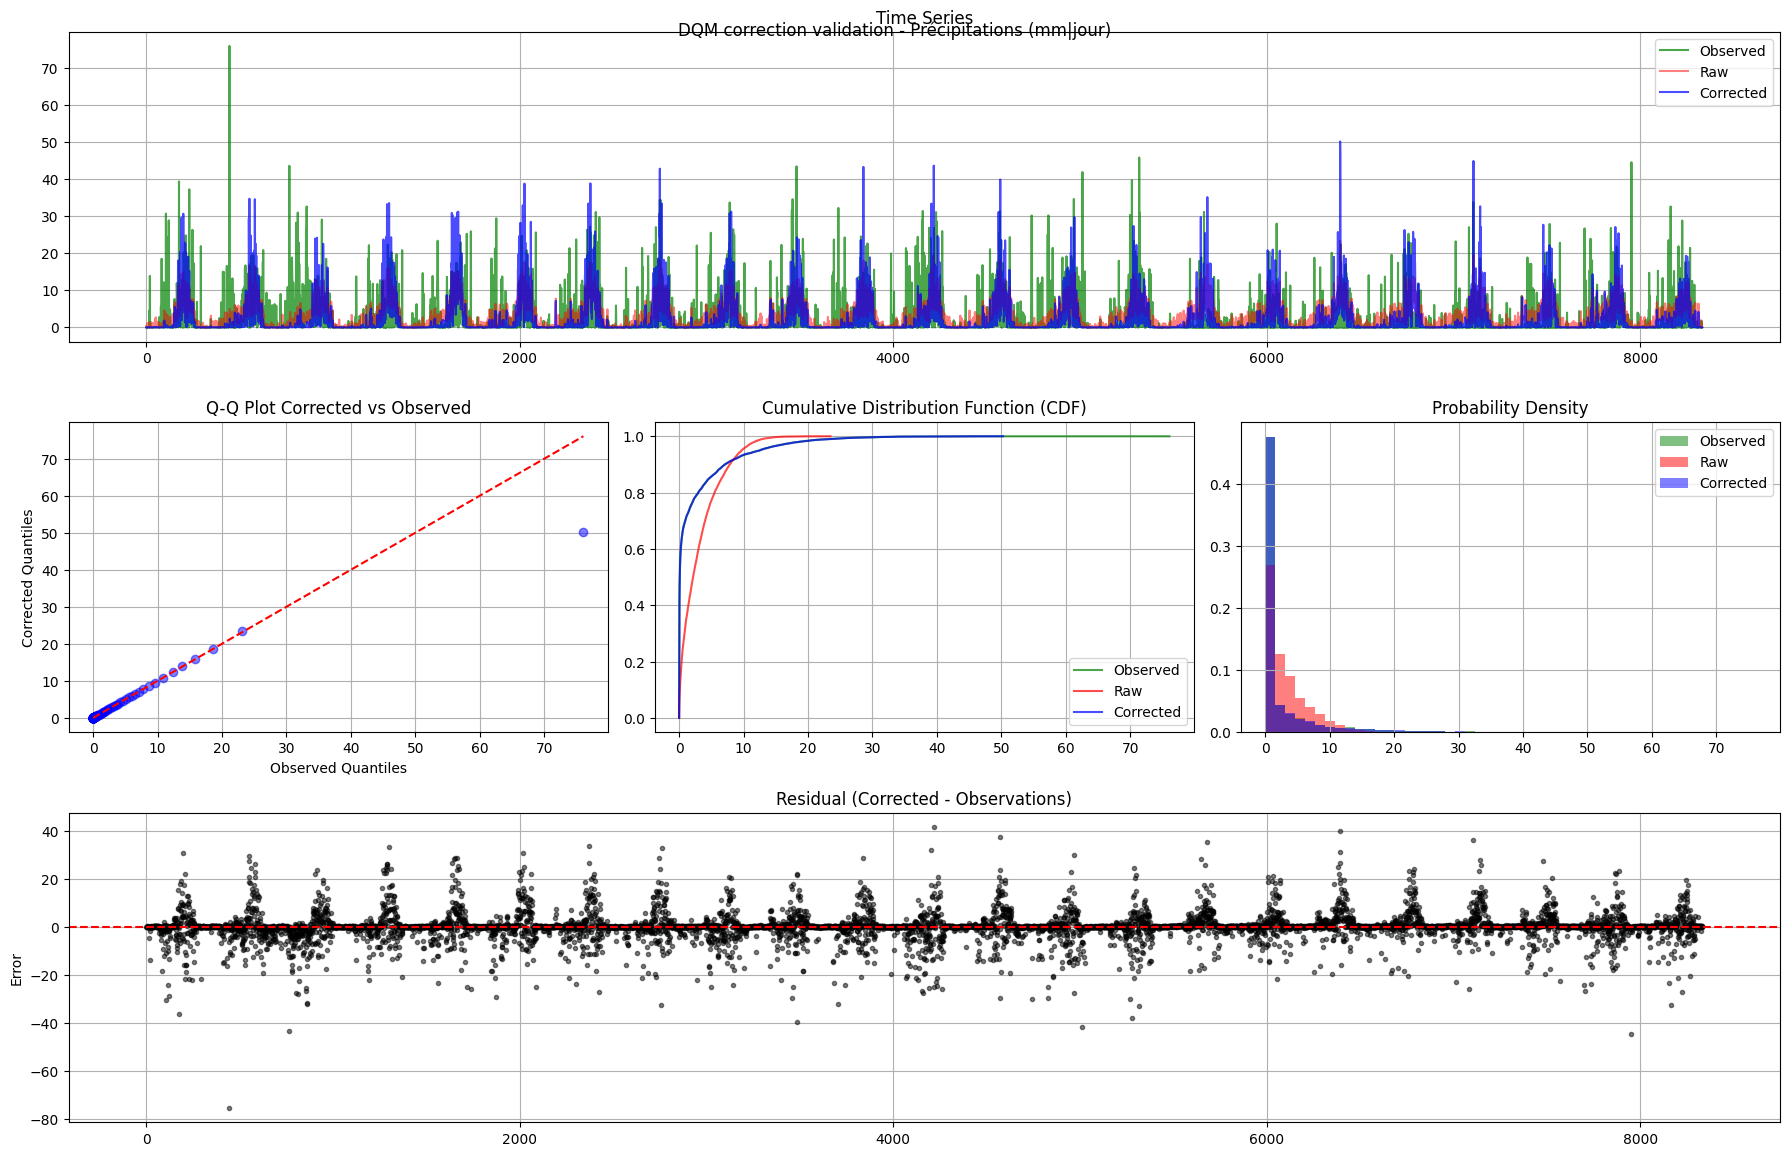

Metrics saved to /content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/training/dqm_traning_mtrics.csv
{'RMSE Brut': np.float32(4.9495378), 'RMSE Corrige': np.float64(5.811715699455798), 'Biais Brut': np.float32(0.9851302), 'Biais Corrige': np.float64(0.019622077227140444), 'Corrélation Brut': np.float64(0.3188041146841261), 'Corrélation Corrige': np.float64(0.267200570663421), 'KS-test p-value': np.float64(0.0)}


In [ ]:
# Entraînement sur la période historique
step = "training"
corrected_train, corrector = dqm.dqm(
    o=_obs_for_corrector.loc[ind_train, 'precip'].values,
    p=_hist_for_corrector.loc[ind_train, 'precip'].values,
    s=_hist_for_corrector.loc[ind_train, 'precip'].values,
    precip=True,
    pr_threshold=0.1
)

# Validation sur la période de test
metrics_train = dqm.validate_dqm_correction(
        obs=_obs_for_corrector.loc[ind_train , 'precip'].values,
        raw=_hist_for_corrector.loc[ind_train , 'precip'].values,
        corrected=corrected_train,
        directory=directory_training,
        #corrector=corrector,
        variable_name="Précipitations (mm|jour)"
    )

manage_files.save_metrics(metrics_train, 'dqm_traning_mtrics.csv', directory_training)
print(metrics_train)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/validation/dqm_précipitations (mm|jour).png


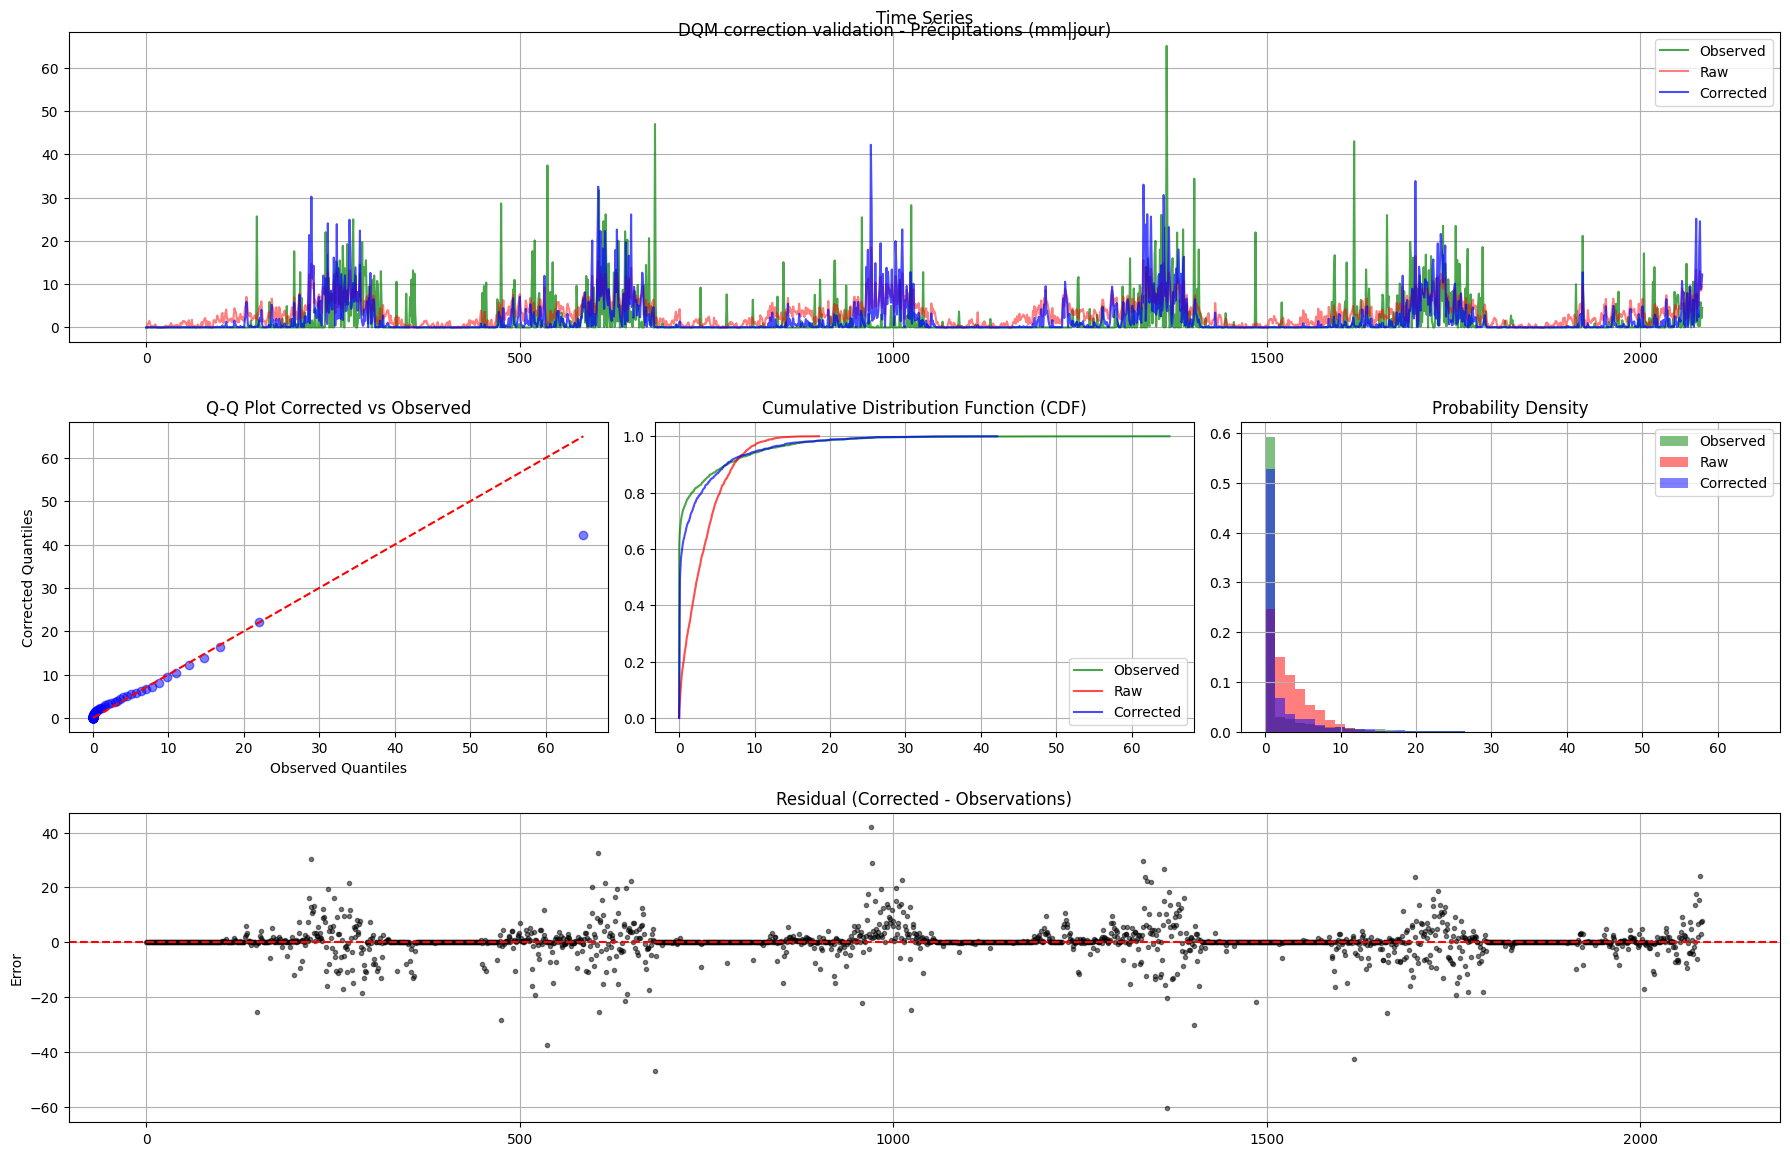

Metrics saved to /content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/validation/dqm_traning_metrics.csv
{'RMSE Brut': np.float32(4.8941746), 'RMSE Corrige': np.float64(5.519367393959175), 'Biais Brut': np.float32(1.3912498), 'Biais Corrige': np.float64(0.22868871896735146), 'Corrélation Brut': np.float64(0.3056393849982053), 'Corrélation Corrige': np.float64(0.24369983904063733), 'KS-test p-value': np.float64(1.0907341360500466e-300)}


In [ ]:
# Application aux projections futures
corrected_test = dqm.apply_dqm(
    _hist_for_corrector.loc[ind_test , 'precip'].values,
    corrector
)

step = "validation"
# Validation sur la période de test
metrics_test = dqm.validate_dqm_correction(
        obs=_obs_for_corrector.loc[ind_test , 'precip'].values,
        raw=_hist_for_corrector.loc[ind_test , 'precip'].values,
        corrected=corrected_test,
        directory=directory_validation,
        #corrector=corrector,
        variable_name="Précipitations (mm|jour)"
    )
manage_files.save_metrics(metrics_test, 'dqm_traning_metrics.csv', directory_validation)
print(metrics_test)

In [ ]:
extends_metrics_test = dqm.calculate_extended_metrics(
    _obs_for_corrector.loc[ind_test , 'precip'].values,
    _hist_for_corrector.loc[ind_test , 'precip'].values,
    corrected_test)

manage_files.save_metrics(extends_metrics_test, 'dqm_traning_extends_metrics', directory_validation)

print(extends_metrics_test)

Metrics saved to /content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/validation/dqm_traning_extends_metrics
{'RMSE Brut': np.float32(4.8941746), 'RMSE Corrige': np.float64(5.519367393959175), 'Biais Brut': np.float32(1.3912498), 'Biais Corrige': np.float64(0.22868871896735146), 'R95p Brut': np.float32(-2.1019278), 'R95p Corrige': np.float64(-0.5212684564818133), 'Dry Days Brut': np.int64(-1264), 'Dry Days Corrige': np.int64(-383), 'KS-test p-value': np.float64(1.0907341360500466e-300)}


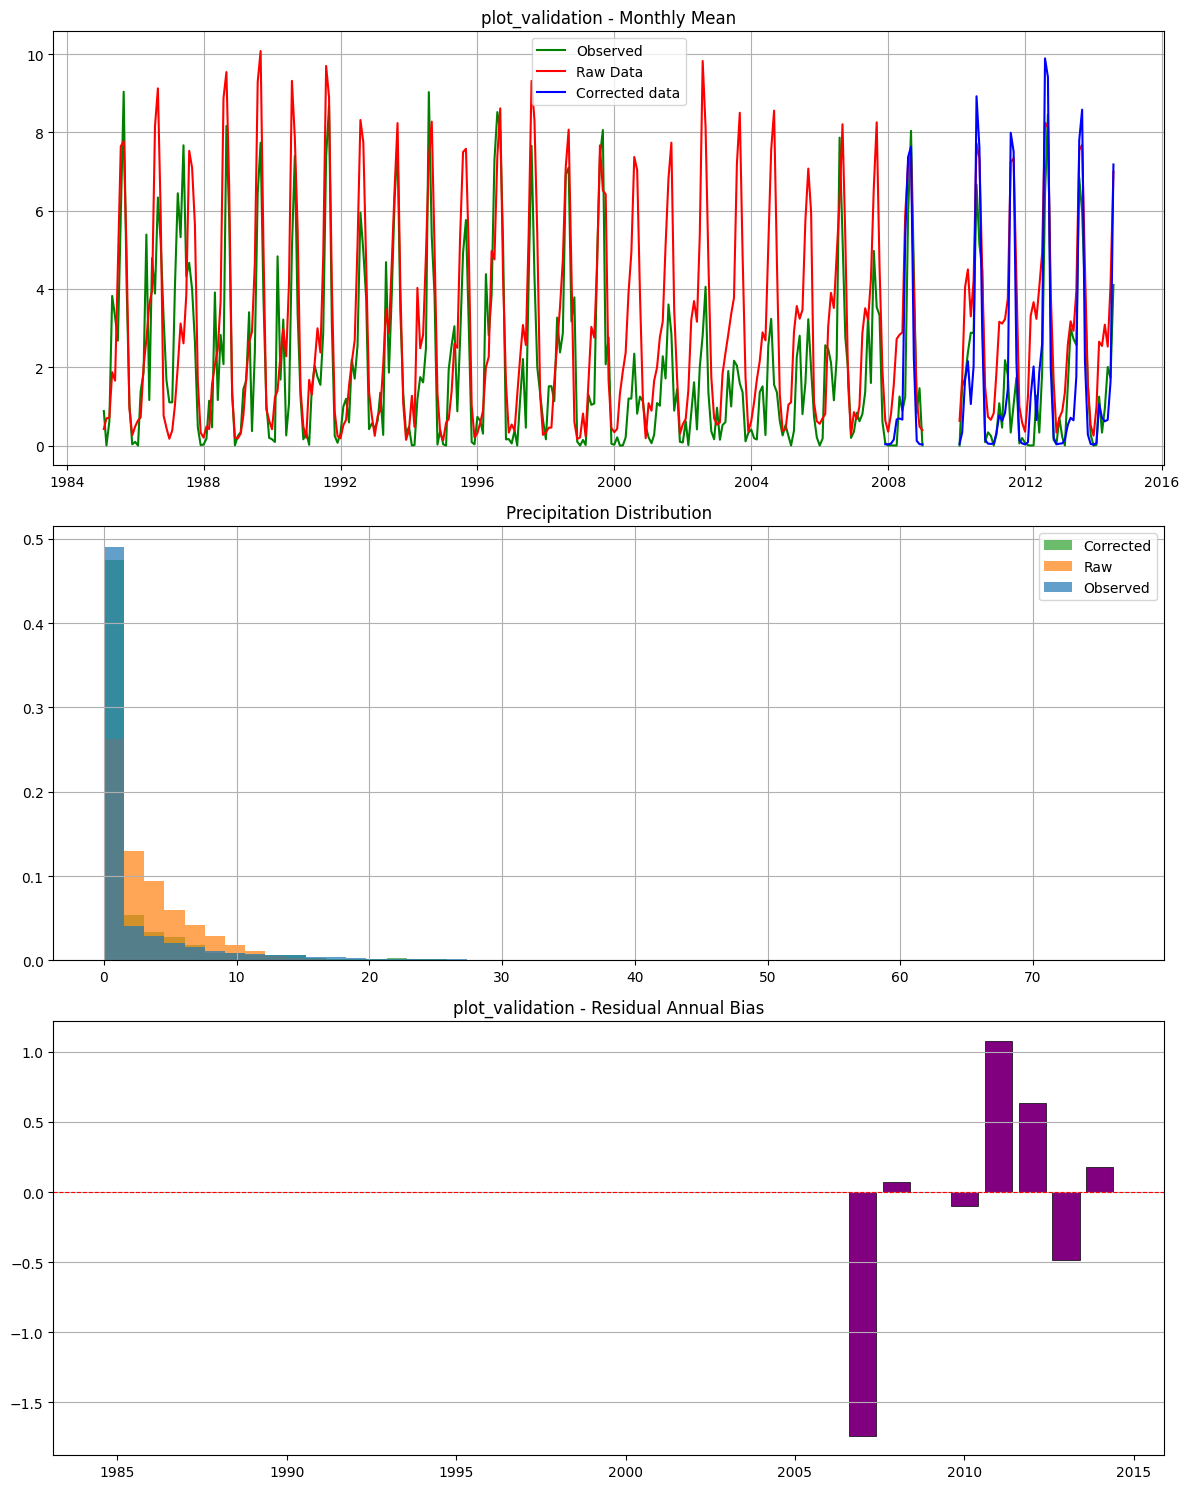

In [ ]:
corrected_test_df = pd.DataFrame({'time': _obs_for_corrector.loc[ind_test, 'time'].values, 'precip': corrected_test})

FIG_ = dqm.plot_climate_validation(
    _obs_for_corrector,
    _hist_for_corrector,
    corrected_test_df,
    "plot_validation",
    directory_validation,
    aggr='M')

In [ ]:
print(_scenar.columns)
_scenar.rename(columns={'pr': 'precip'}, inplace=True)

_scenar.dropna(subset=['time', 'precip'], inplace=True) # Supprime les lignes où 'precip' est NaN
_scenar.reset_index(drop=True, inplace=True) # Remet l'index à 0, 1, 2...
df_model = _scenar.copy()

Index(['time', 'precip'], dtype='object')


/content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/projection/dqm_précipitations (mm|jour).png


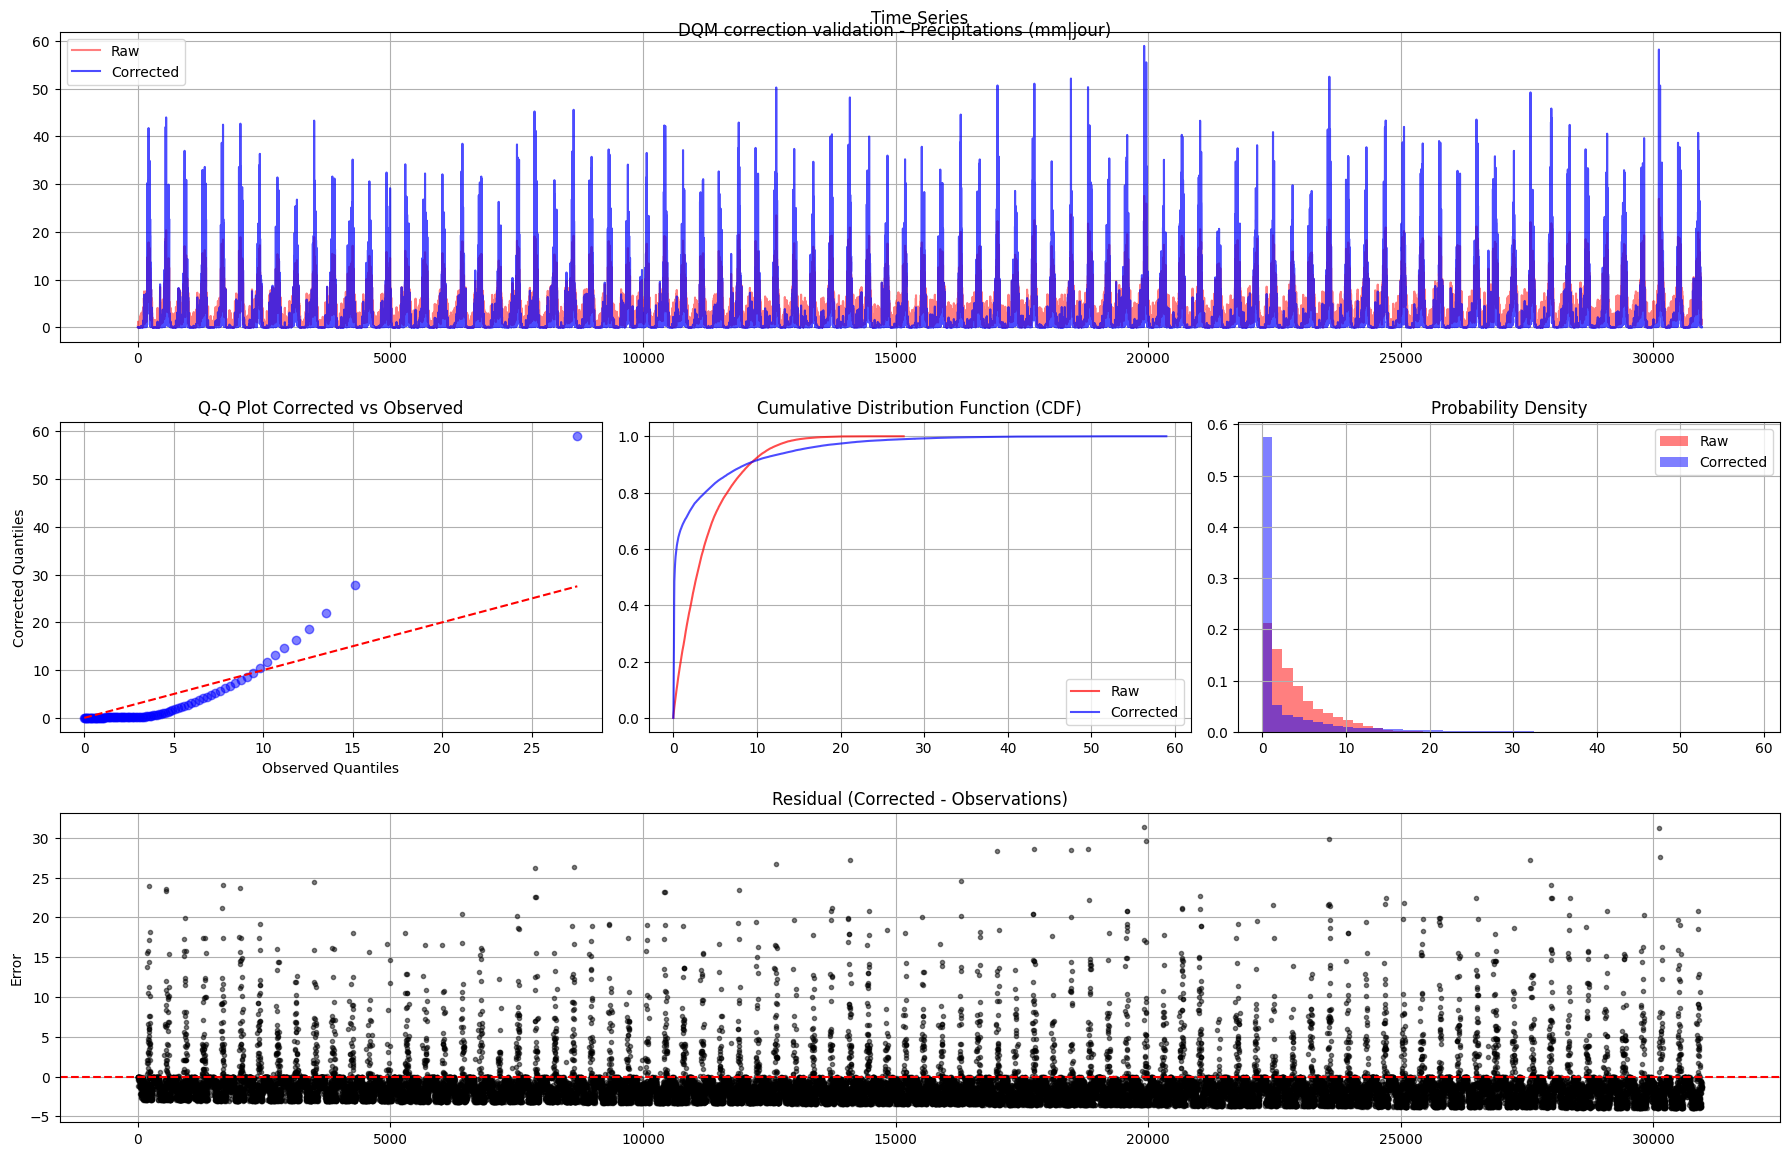

-1


In [ ]:
# Application aux projections futures
projection = dqm.apply_dqm(
    df_model['precip'].values,
    corrector)
projection_df = pd.DataFrame({'time': df_model['time'].values, 'precip_projection': projection})
projection_df.to_csv(directory_projection + f"projection_{scenario}.csv")

step = "projection"
# Validation sur la période de test
metrics_test = dqm.validate_dqm_correction(
        obs=None,
        raw=df_model['precip'].values,
        corrected=projection,
        directory=directory_projection,
        #corrector=corrector,
        variable_name="Précipitations (mm|jour)"
    )
#manage_files.save_metrics(metrics_test, 'dqm_traning_metrics.csv', directory_projection)
print(metrics_test)